# Network Anomaly Detection 
## 01. Data Exploration

### 1. Setup

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [23]:
sns.set(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (10, 5)

### 2. Load Dataset

In [24]:
DATA_FILE = "../../data/raw/nsl_kdd/KDDTrain+_20Percent.txt"  
output_dir = Path("../../results/nslkdd_eda")
output_dir.mkdir(parents=True, exist_ok=True)

In [25]:
# Column names (41 features + label + difficulty)
columns = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent",
    "hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login","is_guest_login",
    "count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
    "dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
    "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"
]

df = pd.read_csv(DATA_FILE, names=columns)
print("Loaded:", df.shape)
df.head()

Loaded: (25192, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


Exploring data

In [26]:
# Basic info
print("Dtypes:")
print(df.dtypes)
print("\nNull counts:")
print(df.isnull().sum())

print("\nUnique labels (sample):")
print(df['label'].value_counts().head(20))


Dtypes:
duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate  

Dataset is clean and requires no NA imputation

#### Convert label into binary 

Attack Label Distribution:
is_attack
0    13449
1    11743
Name: count, dtype: int64


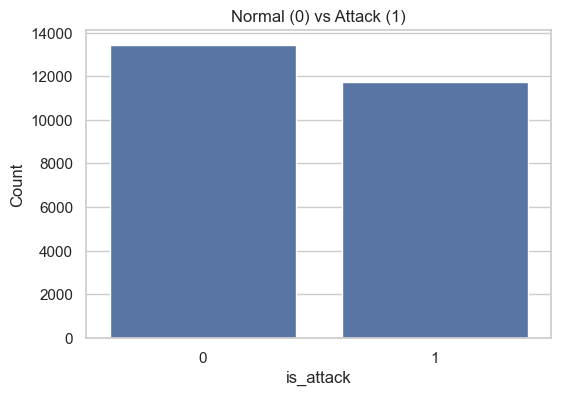

In [27]:
df['is_attack'] = df['label'].apply(lambda x: 0 if x.strip() == 'normal' else 1)

attack_counts = df['is_attack'].value_counts()
print("Attack Label Distribution:")
print(attack_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=attack_counts.index, y=attack_counts.values)
plt.title("Normal (0) vs Attack (1)")
plt.xlabel("is_attack")
plt.ylabel("Count")

plt.savefig(output_dir / "label_balance.png", bbox_inches="tight")
plt.show()


Data is fairly balanced. No resampling needed for this dataset.

#### Attack type distribution

label
normal             13449
neptune             8282
ipsweep              710
satan                691
portsweep            587
smurf                529
nmap                 301
back                 196
teardrop             188
warezclient          181
pod                   38
guess_passwd          10
warezmaster            7
buffer_overflow        6
imap                   5
rootkit                4
multihop               2
phf                    2
ftp_write              1
land                   1
Name: count, dtype: int64

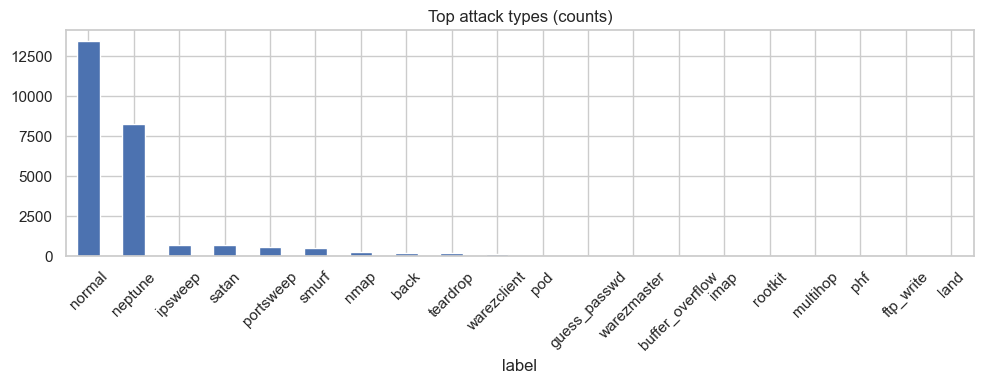

In [28]:
attack_counts = df['label'].value_counts()
display(attack_counts.head(20))
attack_counts.head(20).plot(kind='bar', figsize=(10,4))
plt.title("Top attack types (counts)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir/"attack_types.png")
plt.show()


DoS attack (neptune) dominates the attack classes. Some 'rare attacks' (phf, land, ftp_write) have less than 5 samples, these may lead to overfitting and affect noisy evaluation.

#### Category feature distribution

In [29]:
for col in ['protocol_type','service','flag']:
    ct = pd.crosstab(df[col], df['is_attack'], normalize='index')*100
    print(f"\n--- {col} vs is_attack (% by row) ---")
    display(ct.sort_values(1, ascending=False).head(10))



--- protocol_type vs is_attack (% by row) ---


is_attack,0,1
protocol_type,,
icmp,15.770393,84.229607
tcp,52.036442,47.963558
udp,83.261375,16.738625



--- service vs is_attack (% by row) ---


is_attack,0,1
service,,
name,0.0,100.0
pop_2,0.0,100.0
ldap,0.0,100.0
link,0.0,100.0
login,0.0,100.0
mtp,0.0,100.0
netbios_dgm,0.0,100.0
netbios_ns,0.0,100.0
netbios_ssn,0.0,100.0



--- flag vs is_attack (% by row) ---


is_attack,0,1
flag,,
RSTOS0,0.000000,100.000000
SH,0.000000,100.000000
S0,1.141390,98.858610
RSTR,5.633803,94.366197
RSTO,14.473684,85.526316
OTH,20.000000,80.000000
REJ,23.240072,76.759928
S2,80.952381,19.047619
SF,84.572230,15.427770


ICMP traffic is mostly malicious (84%). TCP is mixed, ML/DL model will need to understand others patterns, not just protocol.

#### Numerical Feature Distribution

In [30]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"Total numerical features: {len(numerical_cols)}")
print("Numerical Columns:")
print(numerical_cols)

print("\n=== Numerical Feature Summary ===")
df[numerical_cols].describe().T


Total numerical features: 40
Numerical Columns:
['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'difficulty', 'is_attack']

=== Numerical Feature Summary ===


,count,mean,std,min,25%,50%,75%,max
duration,25192.0,305.054104,2.686556e+03,0.0,0.00,0.00,0.00,42862.0
src_bytes,25192.0,24330.628215,2.410805e+06,0.0,0.00,44.00,279.00,381709090.0
dst_bytes,25192.0,3491.847174,8.883072e+04,0.0,0.00,0.00,530.25,5151385.0
land,25192.0,0.000079,8.909946e-03,0.0,0.00,0.00,0.00,1.0
wrong_fragment,25192.0,0.023738,2.602208e-01,0.0,0.00,0.00,0.00,3.0
urgent,25192.0,0.000040,6.300408e-03,0.0,0.00,0.00,0.00,1.0
hot,25192.0,0.198039,2.154202e+00,0.0,0.00,0.00,0.00,77.0
num_failed_logins,25192.0,0.001191,4.541818e-02,0.0,0.00,0.00,0.00,4.0
logged_in,25192.0,0.394768,4.888105e-01,0.0,0.00,0.00,1.00,1.0
num_compromised,25192.0,0.227850,1.041735e+01,0.0,0.00,0.00,0.00,884.0


Some features have small ranges while the others can reach very large values. This indicates that feature scaling will be necessary before training models.

#### Corelation Analysis

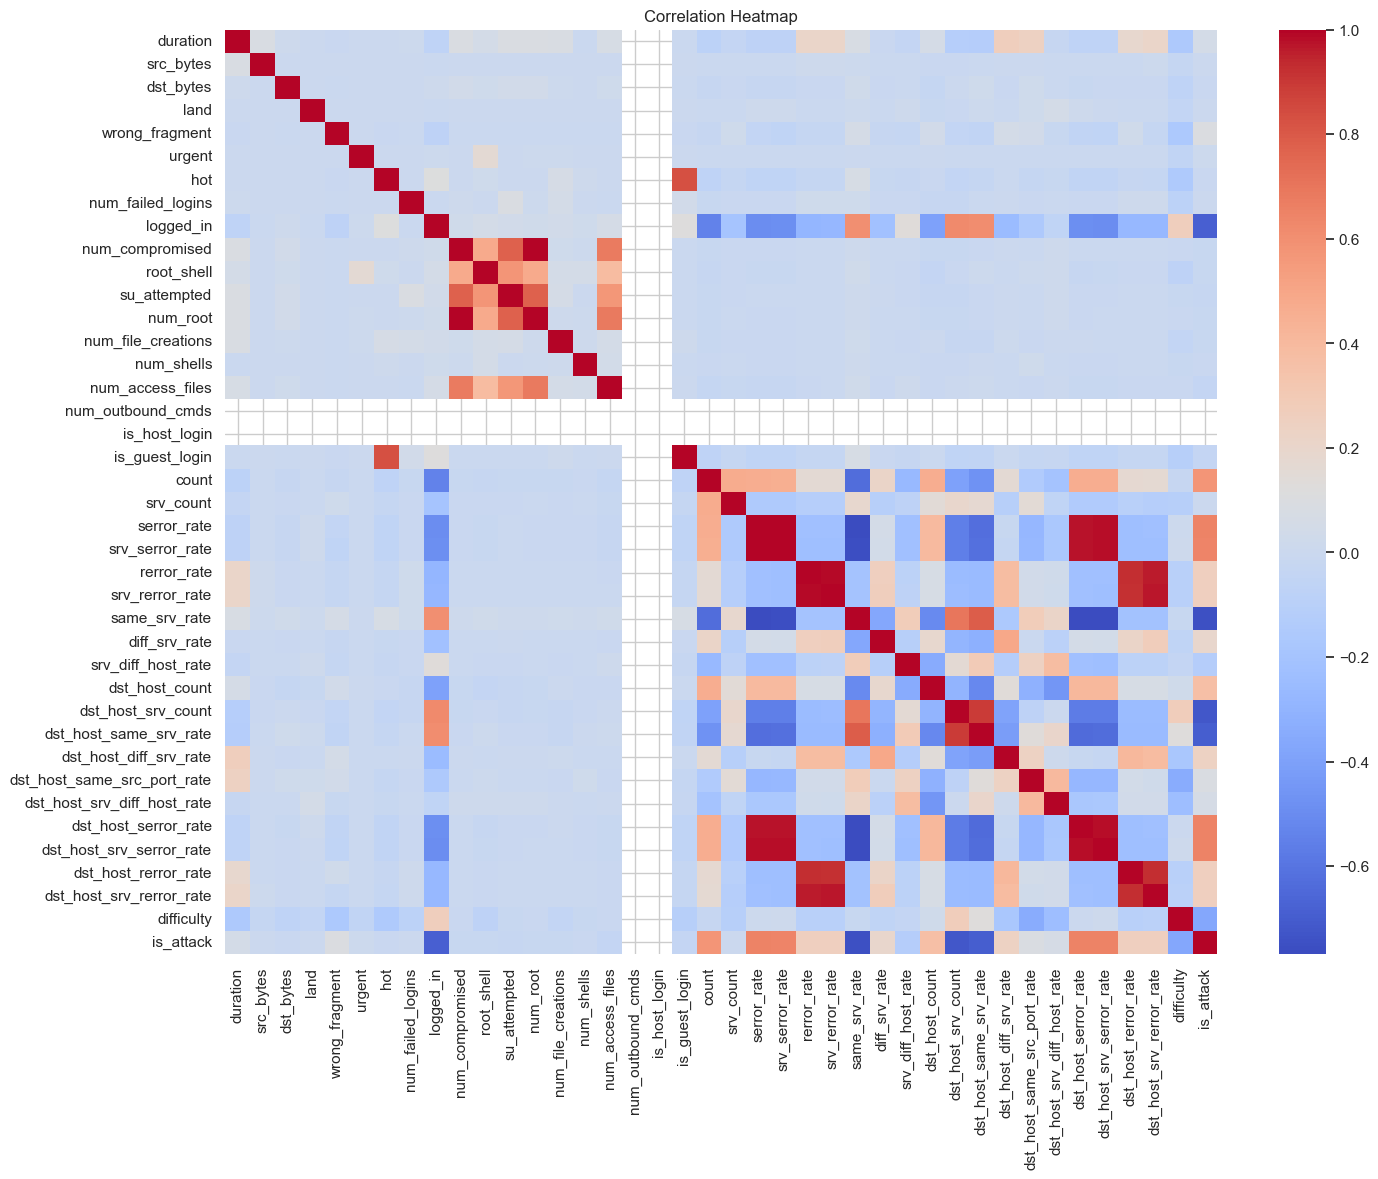

In [31]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(16, 12))
corr = df[numerical_cols].corr()
sns.heatmap(corr, cmap="coolwarm", square=False)
plt.title("Correlation Heatmap")
plt.show()


Heatmap results show pretty high correlation among `serror_rate`, `srv_serror_rate`, `dst_host_serror_rate`, `dst_host_srv_serror_rate`. These groups are redundant features and need to be handle in next phase.

#### Feature relevance 

In [32]:
from sklearn.feature_selection import f_classif

X_num = df[numerical_cols]
y_label = df["is_attack"]

f_scores, p_values = f_classif(X_num, y_label)

feature_scores = (
    pd.DataFrame({
        "Feature": numerical_cols,
        "F-score": f_scores,
        "p-value": p_values
    })
    .sort_values(by="F-score", ascending=False)
)

feature_scores.head(20)


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [16 17 39] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


,Feature,F-score,p-value
39,is_attack,inf,0.000000e+00
25,same_srv_rate,3.223702e+04,0.000000e+00
29,dst_host_srv_count,2.700433e+04,0.000000e+00
30,dst_host_same_srv_rate,2.317392e+04,0.000000e+00
8,logged_in,2.265057e+04,0.000000e+00
35,dst_host_srv_serror_rate,1.880240e+04,0.000000e+00
34,dst_host_serror_rate,1.853247e+04,0.000000e+00
21,serror_rate,1.842435e+04,0.000000e+00
22,srv_serror_rate,1.821614e+04,0.000000e+00
19,count,1.268957e+04,0.000000e+00


4 features with high F-score is important: `same_srv_rate`,`dst_host_srv_count`,`dst_host_same_srv_rate`,`logged_in`

### 3. Summary
This is a clean balanced dataset without any missing values. Some categorical values perfectly predict attack, some features are heavily correlated.